# News summary maker

## Index
1.  Today's essential concept  
2. Real typing pre-learn modeling
3. Module
4. Get the dataset
5. Look into dataset
6. Data Preprocessing
7. Attention Module
8. Abstract Summary
9. Extract Summary & Final result

회고
1. 내용 정리
2. 익스를 하며

In [113]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import numpy as np
import pandas as pd

import os

import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import requests
from summa.summarizer import summarize

import urllib.request

import pickle
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
tf.random.set_seed(77)
np.random.seed(77)

In [115]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [116]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [117]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [118]:
# data.sample() is same code
for idx in range(5):
    tmp = np.random.randint(100000)
    print(data['Text'][tmp])
    print(data['Summary'][tmp])
    print()

This is the best vanilla extract I have ever tasted. For the longest time I hated how regular vanilla extract tasted. I went looking for alternatives and found this. The vanilla flavor is very true to real vanilla flavor. Alcohol free tastes so much better. The price difference is worth it because what you get in taste is equal or greater.<br /><br />I have purchased this direct from Olive Nation and also through Amazon.
Excellent Vanilla Extract

This hot sause isnt for the weak, if you, or know someone who's like me, able to drink <a href="http://www.amazon.com/gp/product/B002HNS55A">TABASCO® brand Pepper Sauce - Original Red Gallon</a>without taking a drink then this is the perfect sause. We finally got a Mexican Tienda in our town and i buy this from him everytime i visit this family owned and ran store. I have ALOT of it put up for survival / food storage reasons, and inflation fears. I had quite a few Mayan salsas during our trip to the Yucatan and this is pretty close to the sam

In [119]:
cool_data = pd.DataFrame()
cool_data['Text'] = data['Text']
cool_data['Summary'] = data['Summary']
cool_data.head()

# data=data[['Text', 'Summary']]

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [120]:
cool_data['Text'].nunique(), cool_data['Summary'].nunique()

(88426, 72348)

In [121]:
cool_data.drop_duplicates(subset = ['Text'], inplace=True)

In [122]:
cool_data.dropna(inplace=True)

In [123]:
len(cool_data)

88425

In [124]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [125]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [126]:
# we need to check NaN value in text after text preprocessing; this code is not typed
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() 
    sentence = BeautifulSoup(sentence, "lxml").text # html tag
    sentence = re.sub(r'\([^)]*\)', '', sentence) 
    sentence = re.sub('"','', sentence) 
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])# contraction
    sentence = re.sub(r"'s\b","", sentence) # possesive case
    sentence = re.sub("[^a-zA-Z]", " ", sentence) 
    sentence = re.sub('[m]{2,}', 'mm', sentence) # Ex) ummmmmmm yeah -> umm yeah
        
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [127]:
# load data preprocessed; cause it takes long time
file_path = os.getenv("HOME") + '/aiffel/News_maker/data.csv'
data = pd.read_csv(file_path)
data.replace(to_replace='', value=np.nan, inplace=True)
data.dropna(inplace=True)
del data['Unnamed: 0']

print(len(data))
data.head()

88355


,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [128]:
# text_len = [len(s.split()) for s in data['Text']]
num_Text = []
for i in data['Text']:
    num_Text.append(len(i.split()))

data['num_Text'] = np.array(num_Text, dtype=np.int64)
data.head()

,Text,Summary,num_Text
0,bought several vitality canned dog food produc...,good quality dog food,23
1,product arrived labeled jumbo salted peanuts p...,not as advertised,18
2,confection around centuries light pillowy citr...,delight says it all,39
3,looking secret ingredient robitussin believe f...,cough medicine,17
4,great taffy great price wide assortment yummy ...,great taffy,13


In [129]:
num_summary = [len(x.split()) for x in data['Summary']]
data['num_summary'] = np.array(num_summary)
data.head()

,Text,Summary,num_Text,num_summary
0,bought several vitality canned dog food produc...,good quality dog food,23,4
1,product arrived labeled jumbo salted peanuts p...,not as advertised,18,3
2,confection around centuries light pillowy citr...,delight says it all,39,4
3,looking secret ingredient robitussin believe f...,cough medicine,17,2
4,great taffy great price wide assortment yummy ...,great taffy,13,2


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88355 entries, 0 to 88354
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         88355 non-null  object
 1   Summary      88355 non-null  object
 2   num_Text     88355 non-null  int64 
 3   num_summary  88355 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.4+ MB


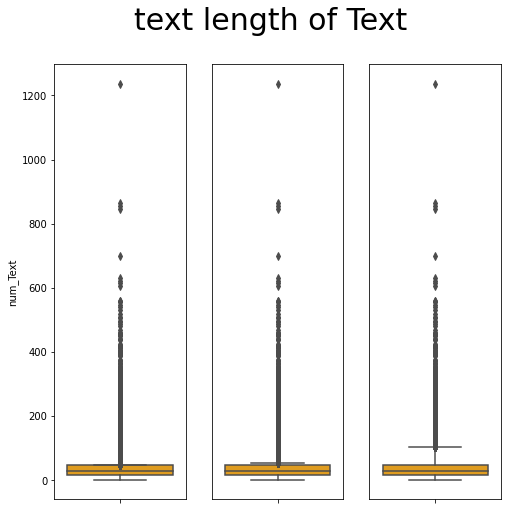

In [131]:
plt.figure(figsize=(8, 8))
plt.suptitle('text length of Text', fontsize=30)

#whisker range 60
plt.subplot(131)
sns.boxplot(data=data, y='num_Text', whis=[0, 60], color='orange')

#whisker range 80
plt.subplot(132)
plt.tick_params(left=False, labelleft=False)
sns.boxplot(data=data, y='num_Text', whis=[0, 80], color='orange').set_ylabel('')

#whisker range 95
plt.subplot(133)
plt.tick_params(left=False, labelleft=False)
sns.boxplot(data=data, y='num_Text', whis=[0, 95], color='orange').set_ylabel('')

plt.show()

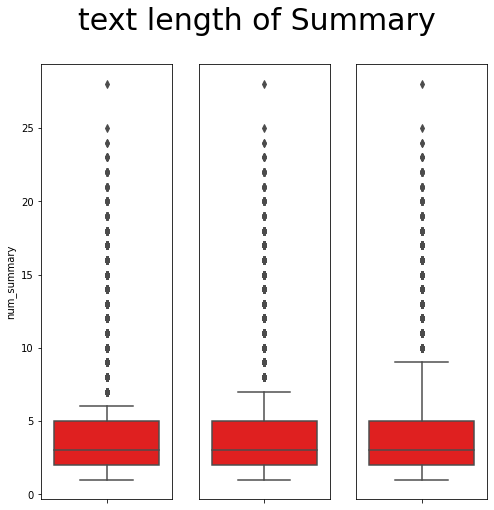

In [132]:
plt.figure(figsize=(8, 8))
plt.suptitle('text length of Summary', fontsize=30)

#whisker range 80
plt.subplot(131)
sns.boxplot(data=data, y='num_summary', whis=[0, 80], color='red')

#whisker range 90
plt.subplot(132)
plt.tick_params(left=False, labelleft=False)
sns.boxplot(data=data, y='num_summary', whis=[0, 90], color='red').set_ylabel('')

#whisker range 95
plt.subplot(133)
plt.tick_params(left=False, labelleft=False)
sns.boxplot(data=data, y='num_summary', whis=[0, 95], color='red').set_ylabel('')

plt.show()

In [133]:
np.round(np.mean(data['num_Text']), 2), np.round(np.mean(data['num_summary']), 2)

(38.79, 4.01)

In [134]:
text_max_len = 50
summary_max_len = 8

In [135]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

len(data)

65818

In [136]:
data['dec_input'] = data['Summary'].apply(lambda x: 'sostoken ' +x)
data['dec_output'] = data['Summary'].apply(lambda x: x+' eostoken')
data.head()

,Text,Summary,num_Text,num_summary,dec_input,dec_output
0,bought several vitality canned dog food produc...,good quality dog food,23,4,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,18,3,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,39,4,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,17,2,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,13,2,sostoken great taffy,great taffy eostoken


In [137]:
enc_input = data['Text'].values
dec_input = data['dec_input'].values
dec_output = data['dec_output'].values

In [138]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
indices

array([  871, 62152, 54923, ..., 37600, 25503,  7832])

In [139]:
enc_input = enc_input[indices]
dec_input = dec_input[indices]
dec_output = dec_output[indices]

In [140]:
# ratio train:test
r = int(enc_input.shape[0] * 0.8)

enc_input_train = enc_input[:r]
dec_input_train = dec_input[:r]
dec_output_train = dec_output[:r]

enc_input_test = enc_input[r:]
dec_input_test = dec_input[r:]
dec_output_test = dec_output[r:]

r, r//4

(52654, 13163)

In [141]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(enc_input_train)

len(src_tokenizer.word_index)

32011

In [142]:
threshold = 7
rare_cnt = 0
rare_freq = 0
freq = 0
print_cnt = 0

for key, value in src_tokenizer.word_counts.items():
    freq += value

    if value <= threshold:
        rare_cnt += 1
        rare_freq += value
    
    if value <= threshold and print_cnt <= 20:
        print_cnt += 1
        print((key, value))

ratio_rare_all = rare_cnt/len(src_tokenizer.word_index)

print()
print('희소한 단어 비율: {:0.2f}%'.format(ratio_rare_all*100))
print('희소한 단어 빈도수 비율: {:0.2f}%'.format(rare_freq/freq*100))

('interestingly', 5)
('cracking', 4)
('strategically', 2)
('richly', 6)
('sooooooooooooooooooo', 1)
('radiation', 5)
('pooches', 6)
('insists', 6)
('hamster', 5)
('beas', 1)
('bogus', 3)
('criticize', 2)
('zoom', 5)
('brownish', 7)
('defects', 2)
('observed', 5)
('chico', 2)
('maisie', 1)
('jane', 7)
('booth', 4)
('lager', 4)

희소한 단어 비율: 76.21%
희소한 단어 빈도수 비율: 3.73%


In [143]:
# reduce token size
len(src_tokenizer.word_index) - int(len(src_tokenizer.word_index)*ratio_rare_all)

7615

In [144]:
src_vocab_size = 7615

src_tokenizer = Tokenizer(num_words=src_vocab_size)
src_tokenizer.fit_on_texts(enc_input_train)

# this value is still same after we give it the number of words; but tokenizer works good
len(src_tokenizer.word_docs)

32011

In [145]:
enc_input_train = src_tokenizer.texts_to_sequences(enc_input_train)
enc_input_test = src_tokenizer.texts_to_sequences(enc_input_test)

In [146]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(dec_input_train)

len(tar_tokenizer.word_index)

10419

In [147]:
threshold = 6
rare_cnt = 0
rare_freq = 0
freq = 0
print_cnt = 0

for key, value in tar_tokenizer.word_counts.items():
    freq += value

    if value <= threshold:
        rare_cnt += 1
        rare_freq += value
    
    if value <= threshold and print_cnt <= 20:
        print_cnt += 1
        print((key, value))

ratio_rare_all = rare_cnt/len(tar_tokenizer.word_index)

print()
print('희소한 단어 비율: {:0.2f}%'.format(ratio_rare_all*100))
print('희소한 단어 빈도수 비율: {:0.2f}%'.format(rare_freq/freq*100))

('student', 3)
('tacs', 3)
('coming', 6)
('hamster', 1)
('zoom', 1)
('chico', 2)
('michelada', 1)
('india', 5)
('freshen', 1)
('snapple', 2)
('safely', 2)
('westie', 2)
('coca', 6)
('detox', 4)
('mckee', 1)
('ky', 2)
('decortating', 1)
('recomended', 5)
('directly', 1)
('distributor', 2)
('senna', 2)

희소한 단어 비율: 79.26%
희소한 단어 빈도수 비율: 6.41%


In [148]:
# reduce token size
len(tar_tokenizer.word_index) - int(len(tar_tokenizer.word_index)*ratio_rare_all)

2161

In [149]:
# fit_on_texts; input and output
tar_vocab_size = 2161

tar_tokenizer = Tokenizer(num_words=tar_vocab_size)
tar_tokenizer.fit_on_texts(dec_input_train)
tar_tokenizer.fit_on_texts(dec_output_train)

dec_input_train = tar_tokenizer.texts_to_sequences(dec_input_train)
dec_input_test = tar_tokenizer.texts_to_sequences(dec_input_test)

dec_output_train = tar_tokenizer.texts_to_sequences(dec_output_train)
dec_output_test = tar_tokenizer.texts_to_sequences(dec_output_test)


In [150]:
dec_input_train[0]

[1, 1673, 490]

In [151]:
# look into target dataset(summary) cause it can hold 'only token'
# it is larger than I thot it would be; need to get rid of it
dataset = dec_input_train + dec_input_test + dec_output_train + dec_output_test
cnt = 0

for data in dataset:
    if len(data) <= 1:
        cnt += 1
len(dataset), cnt

(131636, 2988)

In [152]:
drop_train = [index for index, sentence in enumerate(dec_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(dec_input_test) if len(sentence) == 1]

enc_input_train = [sentence for index, sentence in enumerate(enc_input_train) if index not in drop_train]
dec_input_train = [sentence for index, sentence in enumerate(dec_input_train) if index not in drop_train]
dec_output_train = [sentence for index, sentence in enumerate(dec_output_train) if index not in drop_train]

enc_input_test = [sentence for index, sentence in enumerate(enc_input_test) if index not in drop_test]
dec_input_test = [sentence for index, sentence in enumerate(dec_input_test) if index not in drop_test]
dec_output_test = [sentence for index, sentence in enumerate(dec_output_test) if index not in drop_test]

In [153]:
enc_input_train = pad_sequences(enc_input_train, maxlen=text_max_len, padding='post')
enc_input_test = pad_sequences(enc_input_test, maxlen=text_max_len, padding='post')
dec_input_train = pad_sequences(dec_input_train, maxlen=summary_max_len, padding='post')
dec_output_train = pad_sequences(dec_output_train, maxlen=summary_max_len, padding='post')
dec_input_test = pad_sequences(dec_input_test, maxlen=summary_max_len, padding='post')
dec_output_test = pad_sequences(dec_output_test, maxlen=summary_max_len, padding='post')

In [154]:
# 여기선 부턴 copy
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [155]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [156]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 128)      974720      input_11[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 50, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [157]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 128)      974720      input_11[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 50, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [158]:
# load model
model_flag = False

try:
    model_flag = tf.keras.models.load_model(os.getenv("HOME") + '/aiffel/model_riview')
except:
    print('yo')

In [159]:
# if load_model is empty, let's train model, otherwise we get the model from the saved
if not model_flag:
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    history = model.fit(x=[enc_input_train, dec_input_train], y=dec_output_train, \
          validation_data=([enc_input_test, dec_input_test], dec_output_test), \
          batch_size=256, callbacks=[es], epochs=50)
else:
    model = model_flag
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      974720      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [160]:
# save the model
if not model_flag:
    model.save(os.getenv("HOME") + '/aiffel/model_review')

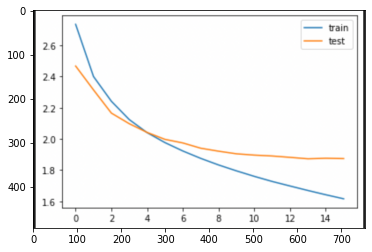

In [161]:
if not model_flag:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
else:
    path = os.getenv("HOME") + '/aiffel/history_review.png'
    img = Image.open(path)
    plt.imshow(img)
    plt.show()


In [162]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [163]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [164]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [165]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [166]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [167]:
for i in range(3):
    print("원문 :", seq2text(enc_input_test[i]))
    print("실제 요약 :", seq2summary(dec_input_test[i]))
    print("예측 요약 :", decode_sequence(enc_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : remember shake bake years ago quick easy use pork comes moist tender grand kids enjoyed shaking pork chops even mild flavor even sprinkled remaining crumbs top chops even comes variety flavors 
실제 요약 : shake bake pork pouch ounce 
예측 요약 :  nice ordered thrilled peppermint pearl disappointment safe


원문 : stuff good amazing jar sauce could recommend highly 
실제 요약 : will make this short 
예측 요약 :  nice bodied beat puffed bodied garlic bodied


원문 : started buying nature valley brand type bars must admit flavor wise superior slightly eat organic sticking bb brand believe like peanut butter bars honestly better peanut butter pie 
실제 요약 : these are excellent 
예측 요약 :  nice ordered canidae portable peppermint peppermint pill




In [168]:
# Extract summarization
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

print(text[:1500])
len(text)

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

35932

In [169]:
print(summarize(text, ratio=0.005))

Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


___
___
<br> <br>
### Module
---

In [170]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import numpy as np
import pandas as pd

import os

import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import requests
from summa.summarizer import summarize

import urllib.request

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
# fix random seed
tf.random.set_seed(77)
np.random.seed(77)

### Get the dataset
___

In [194]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [195]:
data.sample(10)

,headlines,text
67854,Video shows Eng player Stokes mocking model's ...,A day after footage of English cricketer Ben S...
57260,Will name B'wood's sexual offenders if assured...,Richa Chadha has said she'll name and shame se...
69353,"Russia, China hold joint naval drills near Kor...",Russia and China on Monday began the second st...
20182,Al Jazeera may go off air as govt revokes secu...,Qatar-based news channel Al Jazeera may have t...
12137,20-yr-old dance teacher makes fun of man's dan...,"Avinash Sangwan, a 20-year-old dance instructo..."
78817,Nelson Mandela book withdrawn after outrage fr...,A new book detailing Nelson Mandela's last day...
94775,Oil firm BP cuts CEO pay by Ã¢ÂÂ¹48 crore on ...,Oil giant BP has cut CEO Bob Dudley's 2016 pay...
82430,I disagree that AI overlord will control human...,"David Kenny, Senior Vice President for IBM's s..."
33460,Ex-HSBC Bank foreign exchange exec gets 2 year...,"Mark Johnson, the former head of HSBC Bank's f..."
57608,"Artwork shows Trump dressed as Wonder Woman, b...",A painting showing US President Donald Trump d...


### Data Preprocessing
___

In [196]:
# check duplicate
len(data), data['text'].nunique(), data['headlines'].nunique()

(98401, 98360, 98280)

In [197]:
data.drop_duplicates(subset = 'text', inplace=True)

In [198]:
data.dropna(inplace=True)

# then, it means there is no NaN
len(data)

98360

In [199]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [200]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [201]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [202]:
# we need to check NaN value in text after text preprocessing
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() 
    sentence = BeautifulSoup(sentence, "lxml").text # html tag
    sentence = re.sub(r'\([^)]*\)', '', sentence) 
    sentence = re.sub('"','', sentence) 
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])# contraction
    sentence = re.sub(r"'s\b","", sentence) # possesive case
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
        
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [203]:
# with open(os.getenv("HOME")+'/aiffel/news_text.pickle', 'wb') as f:
#     pickle.dump(clean_text, f)

# with open(os.getenv("HOME")+'/aiffel/news_summary.pickle', 'wb') as f:
#     pickle.dump(clean_summary, f)

In [204]:
if False:
    clean_text = []

    for sen in data['text']:
        clean_text.append(preprocess_sentence(sen))

    clean_summary = []

    for sen in data['headlines']:
        clean_summary.append(preprocess_sentence(sen, False))

with open(os.getenv("HOME")+'/aiffel/news_text.pickle', 'rb') as f:
    clean_text = pickle.load(f)

with open(os.getenv("HOME")+'/aiffel/news_summary.pickle', 'rb') as f:
    clean_summary = pickle.load(f)

len(clean_text), len(clean_summary)

(98360, 98360)

In [205]:
data['text'] = np.array(clean_text)
data['summary'] = np.array(clean_summary)

data.dropna(axis=0, inplace=True)

len(data)

98360

In [206]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [207]:
data['num_Text'] = data['text'].apply(lambda x: len(x.split()))
data['num_headlines'] = data['headlines'].apply(lambda x: len(x.split()))

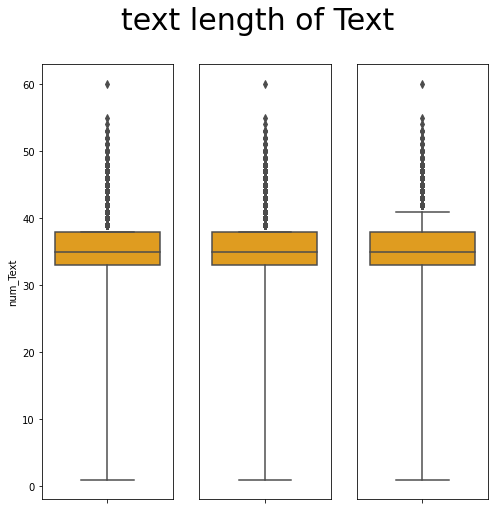

In [208]:
plt.figure(figsize=(8, 8))
plt.suptitle('text length of Text', fontsize=30)

#whisker range 60
plt.subplot(131)
sns.boxplot(data=data, y='num_Text', whis=[0, 60], color='orange')

#whisker range 80
plt.subplot(132)
plt.tick_params(left=False, labelleft=False)
sns.boxplot(data=data, y='num_Text', whis=[0, 80], color='orange').set_ylabel('')

#whisker range 95
plt.subplot(133)
plt.tick_params(left=False, labelleft=False)
sns.boxplot(data=data, y='num_Text', whis=[0, 95], color='orange').set_ylabel('')

plt.show()

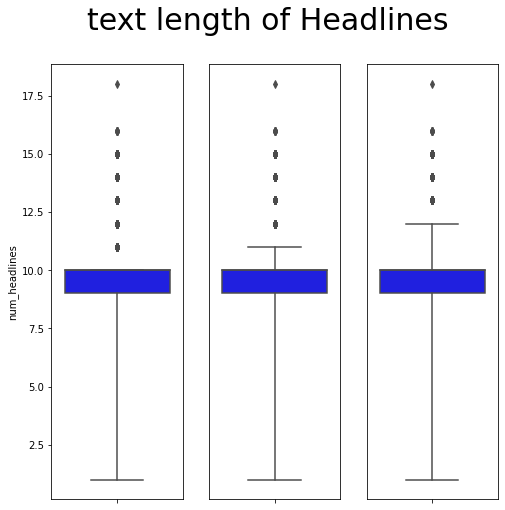

In [209]:
plt.figure(figsize=(8, 8))
plt.suptitle('text length of Headlines', fontsize=30)

#whisker range 60
plt.subplot(131)
sns.boxplot(data=data, y='num_headlines', whis=[0, 60], color='blue')

#whisker range 80
plt.subplot(132)
plt.tick_params(left=False, labelleft=False)
sns.boxplot(data=data, y='num_headlines', whis=[0, 80], color='blue').set_ylabel('')

#whisker range 95
plt.subplot(133)
plt.tick_params(left=False, labelleft=False)
sns.boxplot(data=data, y='num_headlines', whis=[0, 95], color='blue').set_ylabel('')

plt.show()

In [210]:
# from graph, appropriate value for leangh of text, headlines
text_max_len = 38
headlines_max_len = 11

In [223]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data.reset_index(inplace=True, drop=True)
data_ = data

len(data) # before len(data) = 94360

72916

In [228]:
data['dec_input'] = data['headlines'].apply(lambda x: 'sostoken ' +x)
data['dec_output'] = data['headlines'].apply(lambda x: x+' eostoken')
data.head()

,headlines,text,summary,num_Text,num_headlines,dec_input,dec_output
0,"Pune woman accuses ATS officer of thrashing, m...",woman maharashtra pune alleged sub inspector m...,new zealand end rohit sharma led india match w...,38,9,sostoken Pune woman accuses ATS officer of thr...,"Pune woman accuses ATS officer of thrashing, m..."
1,"Ghaziabad teachers found missing from duty, sa...",basic education department officials wednesday...,aegon life iterm insurance plan helps customer...,34,9,sostoken Ghaziabad teachers found missing from...,"Ghaziabad teachers found missing from duty, sa..."
2,Drunk US man who took Ã¢ÂÂ¹1-lakh Uber ride s...,drunk us man accidentally took km uber ride we...,rahat fateh ali khan denies getting notice for...,34,10,sostoken Drunk US man who took Ã¢ÂÂ¹1-lakh Ub...,Drunk US man who took Ã¢ÂÂ¹1-lakh Uber ride s...
3,8 injured as iron bridge collapses in Maharashtra,least eight people injured sunday small iron b...,cong wins ramgarh bypoll in rajasthan takes to...,34,11,sostoken 8 injured as iron bridge collapses in...,8 injured as iron bridge collapses in Maharash...
4,Pic of Chinese woman cooking fish on car bonne...,picture chinese woman cooking fish car bonnet ...,up cousins fed human excreta for friendship wi...,33,9,sostoken Pic of Chinese woman cooking fish on ...,Pic of Chinese woman cooking fish on car bonne...


In [229]:
enc_input = data['text'].values
dec_input = data['dec_input'].values
dec_output = data['dec_output'].values

In [230]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
indices

array([31784, 19032, 58922, ..., 18394, 46319, 35329])

In [231]:
enc_input = enc_input[indices]
dec_input = dec_input[indices]
dec_output = dec_output[indices]

In [232]:
# ratio train to test
r = int(enc_input.shape[0] * 0.8)

enc_input_train = enc_input[:r]
dec_input_train = dec_input[:r]
dec_output_train = dec_output[:r]

enc_input_test = enc_input[r:]
dec_input_test = dec_input[r:]
dec_output_test = dec_output[r:]

r, r//4

(58332, 14583)

In [233]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(enc_input_train)

len(src_tokenizer.word_index)

59538

In [234]:
threshold = 6
rare_cnt = 0
rare_freq = 0
freq = 0
print_cnt = 0

for key, value in src_tokenizer.word_counts.items():
    freq += value

    if value <= threshold:
        rare_cnt += 1
        rare_freq += value
    
    if value <= threshold and print_cnt <= 20:
        print_cnt += 1
        print((key, value))

ratio_rare_all = rare_cnt/len(src_tokenizer.word_index)

print()
print('희소한 단어 비율: {:0.2f}%'.format(ratio_rare_all*100))
print('희소한 단어 빈도수 비율: {:0.2f}%'.format(rare_freq/freq*100))

('patparganj', 1)
('freak', 5)
('contrado', 1)
('hairy', 3)
('spotty', 2)
('bum', 1)
('displacing', 5)
('oskar', 3)
('gr', 3)
('ning', 2)
('bookkeeper', 2)
('resonate', 2)
('puzhal', 2)
('pulp', 3)
('solidified', 5)
('mould', 6)
('claudio', 4)
('marchisio', 3)
('turin', 6)
('anis', 2)
('deceitfully', 2)

희소한 단어 비율: 68.42%
희소한 단어 빈도수 비율: 4.19%


In [235]:
# reduce token size
len(src_tokenizer.word_index) - int(len(src_tokenizer.word_index)*ratio_rare_all)

18803

In [236]:
src_vocab_size = 18796

src_tokenizer = Tokenizer(num_words=src_vocab_size)
src_tokenizer.fit_on_texts(enc_input_train)

# this value is still same after we give it the number of words; but tokenizer works good
len(src_tokenizer.word_docs)

59538

In [237]:
enc_input_train = src_tokenizer.texts_to_sequences(enc_input_train)
enc_input_test = src_tokenizer.texts_to_sequences(enc_input_test)

In [238]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(dec_input_train)

len(tar_tokenizer.word_index)

35539

In [239]:
threshold = 5
rare_cnt = 0
rare_freq = 0
freq = 0
print_cnt = 0

for key, value in tar_tokenizer.word_counts.items():
    freq += value

    if value <= threshold:
        rare_cnt += 1
        rare_freq += value
    
    if value <= threshold and print_cnt <= 20:
        print_cnt += 1
        print((key, value))

ratio_rare_all = rare_cnt/len(tar_tokenizer.word_index)

print()
print('희소한 단어 비율: {:0.2f}%'.format(ratio_rare_all*100))
print('희소한 단어 빈도수 비율: {:0.2f}%'.format(rare_freq/freq*100))

('525', 3)
('syringes', 2)
('iitian', 2)
('freak', 1)
("'hairy", 1)
("leggings'", 1)
('grid', 3)
('races', 4)
('stationery', 1)
('25yrs', 3)
("'pehredaar", 4)
('piya', 5)
("ki'", 3)
('kingpin', 1)
('tripathi', 3)
('mutilate', 1)
("spy's", 3)
('kishor', 2)
('afg', 3)
('payload', 1)
('bins', 3)

희소한 단어 비율: 72.96%
희소한 단어 빈도수 비율: 7.44%


In [240]:
# reduce token size
len(tar_tokenizer.word_index) - int(len(tar_tokenizer.word_index)*ratio_rare_all)

9608

In [241]:
# fit_on_texts; input and output
tar_vocab_size = 9583

tar_tokenizer = Tokenizer(num_words=tar_vocab_size)
tar_tokenizer.fit_on_texts(dec_input_train)
tar_tokenizer.fit_on_texts(dec_output_train)

dec_input_train = tar_tokenizer.texts_to_sequences(dec_input_train)
dec_input_test = tar_tokenizer.texts_to_sequences(dec_input_test)

dec_output_train = tar_tokenizer.texts_to_sequences(dec_output_train)
dec_output_test = tar_tokenizer.texts_to_sequences(dec_output_test)


In [242]:
dec_input_train[0]

[1, 3550, 290, 270, 602, 6, 25, 3, 7, 5624]

In [243]:
enc_input_train = pad_sequences(enc_input_train, maxlen=text_max_len, padding='post')
enc_input_test = pad_sequences(enc_input_test, maxlen=text_max_len, padding='post')
dec_input_train = pad_sequences(dec_input_train, maxlen=summary_max_len, padding='post')
dec_output_train = pad_sequences(dec_output_train, maxlen=summary_max_len, padding='post')
dec_input_test = pad_sequences(dec_input_test, maxlen=summary_max_len, padding='post')
dec_output_test = pad_sequences(dec_output_test, maxlen=summary_max_len, padding='post')

In [245]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [246]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### Attention Module
---

In [247]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 38, 128)      2405888     input_16[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 38, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [248]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[enc_input_train, dec_input_train], y=dec_output_train, \
        validation_data=([enc_input_test, dec_input_test], dec_output_test), \
        batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
228/228 [==============================] - 22s 76ms/step - loss: 6.7439 - val_loss: 6.3640
Epoch 2/50
228/228 [==============================] - 17s 73ms/step - loss: 6.2880 - val_loss: 6.1731
Epoch 3/50
228/228 [==============================] - 17s 74ms/step - loss: 6.0505 - val_loss: 5.9479
Epoch 4/50
228/228 [==============================] - 17s 75ms/step - loss: 5.7278 - val_loss: 5.5998
Epoch 5/50
228/228 [==============================] - 17s 77ms/step - loss: 5.3341 - val_loss: 5.2992
Epoch 6/50
228/228 [==============================] - 17s 77ms/step - loss: 4.9790 - val_loss: 5.0661
Epoch 7/50
228/228 [==============================] - 17s 76ms/step - loss: 4.6865 - val_loss: 4.9193
Epoch 8/50
228/228 [==============================] - 17s 76ms/step - loss: 4.4420 - val_loss: 4.8070
Epoch 9/50
228/228 [==============================] - 17s 76ms/step - loss: 4.2254 - val_loss: 4.7363
Epoch 10/50
228/228 [==============================] - 17s 76ms/step - loss: 4.031

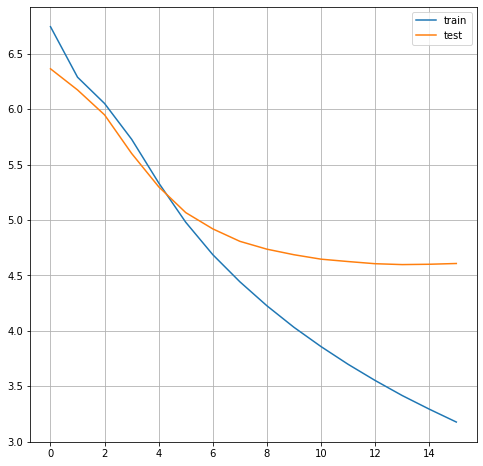

In [249]:
plt.figure(figsize=(8, 8))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid(True)
plt.legend()
plt.show()

### Abstract Summary
___

In [250]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [251]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [252]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [253]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [254]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [255]:
for i in range(3):
    print("원문 :", seq2text(enc_input_test[i]))
    print("실제 요약 :", seq2summary(dec_input_test[i]))
    print("예측 요약 :", decode_sequence(enc_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : nawazuddin siddiqui said surprised approached portray shiv sena founder bal thackeray biopic titled thackeray extremely happy bollywood want play role came added nawazuddin said actor role worth playing 
실제 요약 : was surprised when i was offered role siddiqui 
예측 요약 :  nawazuddin siddiqui to play in biopic


원문 : sonu ke titu ki sweety actress nushrat said money concern priority quantity matter would like portray something would challenge actor added nushrat reportedly offered crore south indian film refused felt role strong enough 
실제 요약 : a priority for me ke ki ' actress 
예측 요약 :  sonu nigam sonu shaves sonu to sonu


원문 : commerce giant amazon ceo jeff bezos said amazon directly created lakh jobs including people company absorbed acquired companies entire workforce google parent alphabet employees end amazon global employee base lakh 
실제 요약 : added more jobs in than google parent's workforce 
예측 요약 :  amazon to sell for investing in healthcare




### Extract Summary & Final result
___

In [260]:
# now put in two suammary in seires
data = pd.read_csv
data['text'] = data['text'].values[indices]
data['headlines'] = data['headlines'].values[indices]

for i in range(3):
    text = data['text'][r+i]

    print("원문 :", text)
    print("실제 요약 :", data['headlines'][r+i])
    print("예측 요약 :", decode_sequence(enc_input_test[i].reshape(1, text_max_len)))
    print("추출 요약 :", summarize(text, ratio=0.5))
    print('\n')

원문 : union minister nitin gadkari said considering pace work getting completed hopeful river ganga completely clean march added difficult task complete said projects namami gange programme worth crore nearing completion
실제 요약 : Hopeful river Ganga will be totally clean by 2020: Gadkari
예측 요약 :  nawazuddin siddiqui to play in biopic
추출 요약 : 


원문 : finance minister arun jaitley monday said would appropriate congress chief rahul gandhi asked right question namely killed investigation death sohrabuddin sheikh cbi court acquitted accused sohrabuddin case gandhi tweeted one killed kauser bi sohrabuddin shiekh died
실제 요약 : Rahul should ask who killed Sohrabuddin probe: Jaitley
예측 요약 :  sonu nigam sonu shaves sonu to sonu
추출 요약 : 


원문 : billy monger year old driver formula legs amputated high speed crash back finnish driver patrik pasma donington park sunday formula one drivers including lewis hamilton jenson button come forward help raise money treatment care year old
실제 요약 : 17-year-old dr

In [ ]:
print(src_tokenizer.sequences_to_texts(enc_input_test[0].reshape(1, text_max_len)))
data['text'][r]

['north korea removed anti us sold gift shops improvement relations two countries according reports included stamps posters among others replaced items focused positive themes reports added north korea selling spread propaganda us']


'The US government on Friday said that there has been no change in law regarding the H-1B visa system and it continues to be the same as before. "President (Donald) Trump asked for review of the H-1B system. But so far no legislation has been passed on H-1B," the government added. The work visa is popular among Indian IT professionals.'

___
___
# 회고 
## 내용 요약
### 텍스트 요약기
### 요약 방식  
#### Extractive summarization; 추출적 요약  
---  
  
_원문의 문장을 그대로 추출하는 것으로 요약하는 방식._  
  
핵심 문장임을 Binary Classification; 분류 라고 볼 수 있다.  
텍스트 랭크; textrank와 같은 알고리즘을 사용하며 포털 사이트 네이버 기사에서 요약봇을 통해 확인할 수 있다.  
  
단점 : 문단의 문장을 그대로 추출하기 때문에 문장 간 상호연결이 어색하다.  
  
```  
from summa.summarizer import summarize  
  
summarize(text, word=, ratio=, split=)  
```  
  
#### Abstractive summarization; 추상적 요약  
---  
  
_원문의 내용을 토대로 '새로운 내용을 생성'함으로 요약_  
  
RNN을 이용하여 구현한다.  
  
Long term dependency; 장기 의존성 을 해결하기 위해서 LSTM을 사용할 것이며  
아키텍쳐는 sequence to sequence, 추가로 attention  
  
### seq2seq  
_sequence to sequence_  
  
---  

<img src="https://velog.velcdn.com/images/jujemu/post/2dde5c48-d9ad-43be-a2be-a5bbb98850bb/image.png" width="400" height="300">

___출처 : https://arxiv.org/pdf/1812.02303.pdf___
  
encoder -> context vector -> decoder -> 요약 생성  
  
encoder의 마지막 time step의 hidden state -> context vector  
이 때, context vector는 고정  
  
__하지만 attention mechanism을 곁들이면__  
<img src="https://velog.velcdn.com/images/jujemu/post/d2215c0e-23b9-4c2d-bdc5-44e6a32a8176/image.png" width="400" height="300">

___출처 : https://arxiv.org/pdf/1812.02303.pdf___  
  
encoder의 모든 hidden state가 context vector에 가중곱으로 포함  
decoder의 각 예측 마다 가중곱을 달리함  
  
___don' forget train_dataset into decoder must include token of start and end___  
  
___훈련 시에 decoder input data를 넣어줌으로 attention 가중곱을 time step을 학습 시킨다. context vector에 따른 출력이 input과 비교함으로 loss 계산을 한다.___  
  
#### things confused  
seq2seq는 모델인가? 아키텍쳐인가? cell로 쓰이는 LSTM은 모델인가?  
  
### stopwords in NLTK  
_natural language toolkit_  
  
---  
  
자주 등장하지만 유의미한 토큰을 만드는 것에 기여하지 못하는 단어들  
Ex> i me my mine, 조사, 접미사 등  
  
### text data preprocessing  
---  
1. text.lower(); 소문자화  
2. BeautifulSoup(sentence, "lxml").text; html 문구 제거  
3. special character process; by regular expression  
4. removing from possesive case  
5. after preprocessing, we need to check NaN  
  
### text normalization  
---  
같은 의미이지만 표기법이 다른 것들을 표기를 통일시키는 것  
Ex> I'm -> i am  
  
  
## Additional  
### fix random seed  
tf.random.set_seed(42)  
np.random.seed(42)  


## 익스를 통해서
___

loss 변동을 통해 early stop을 배웠다.
유용해 보이지만 초반엔 패러미터를 넉넉하게 설정하여 loss의 절대적인 수준에서 제어할 필요가 있다고 생각한다.
머리에 남기기 위해서 본 익스 전에 amazon review는 직접 타이핑 하는 것으로 전반적인 흐름과 각 library를 기억하고자 했다.

restart를 하여 지금까지의 cell이 정상 작동하는 과정에서 항상 model 학습에 시간이 너무 먹어
pickle과 keras.Model에서 제공하는 save method를 사용했다.
일부 저장이 안되는 문제가 있지만, 현재로는 history를 제외한 나머지는 복구할 수 있는 것으로 보인다.

## 결과 통찰
___
### 첫 번째
원문 : The US government on Friday said that there has been no change in law regarding the H-1B visa system and it continues to be the same as before. "President (Donald) Trump asked for review of the H-1B system. But so far no legislation has been passed on H-1B," the government added. The work visa is popular among Indian IT professionals.
실제 요약 : No change in law for H-1B visa, system remains the same: US
예측 요약 :  us imposes funds to boost tariffs
추출 요약 : The US government on Friday said that there has been no change in law regarding the H-1B visa system and it continues to be the same as before.
But so far no legislation has been passed on H-1B," the government added.
#### 결과
추출 요약의 경우 비율이 절반으로 설정하여 원문을 거의 가져왔음으로 높은 문장력을 보였다. 하지만 예측 요약을 경우에 주체를 정확히 잡았지만 대상이 잘못 잡혀 세금 문제로 오해했다.

### 두 번째
원문 : Virat Kohli became the fastest batsman to hit 52 international hundreds after slamming his third consecutive Test ton against Sri Lanka on Saturday. Kohli achieved the feat in his 350th innings, surpassing Hashim Amla's record of 378 innings. Kohli also became only the third player after Sachin Tendulkar and Ricky Ponting to hit 11 international hundreds in a year.
실제 요약 : Kohli slams 52nd international hundred, fastest to do so
예측 요약 :  tweets user on twitter user
추출 요약 : Kohli also became only the third player after Sachin Tendulkar and Ricky Ponting to hit 11 international hundreds in a year.
#### 결과





In [ ]:
# 없는 단어라서 실제로 token에 있는 것인지 확인
print(tar_tokenizer.word_index['dhoni'])
print(tar_tokenizer.word_counts['dhoni'])

tar_tokenizer.word_index['fir']

361
424


588